# Power Spectrum Host Detection Example Notebook

In this notebook, we will use the functions available from the powerspectrum.py file to check for the presence of hosts in a series of images. First, we will check for hosts in simulated images, where a host is known to be present (or not present). Then, we will test with an example stamp from ZTF data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import multivariate_normal

os.chdir('../py/')
import powerspectrum as ps
os.chdir('../notebooks/')

plt.style.use('../stylesheet/hostless.mplstyle')

## Test on Simulated Data
First, check values of the KS test (or Anderson-Darling test) for when there is no host

In [2]:
def simulate_data(amp, size, show_plots=False):
    """
    """
    background = np.random.normal(0, 1, size=(size, size))

    x, y = np.meshgrid(np.arange(0, size, 1), np.arange(0, size, 1))
    pos = np.dstack((x, y))
    mvn = multivariate_normal(mean=[30, 30], cov=[[30.0, 5.], [8., 18.5]])
    host = (amp)**2 * mvn.pdf(pos)

    data = background + host

    if show_plots:
        fig, ax = plt.subplots(1, 3, figsize=(12,3))

        noise_im = ax[0].imshow(background)
        ax[0].set_title('Pure Noise')
        fig.colorbar(noise_im)

        host_im = ax[1].imshow(host)
        ax[1].set_title('Simulated Host')
        fig.colorbar(host_im)

        data_im = ax[2].imshow(data)
        ax[2].set_title('With Injected Host')
        fig.colorbar(data_im)
        plt.show()
        plt.clf()

    return background, host, data

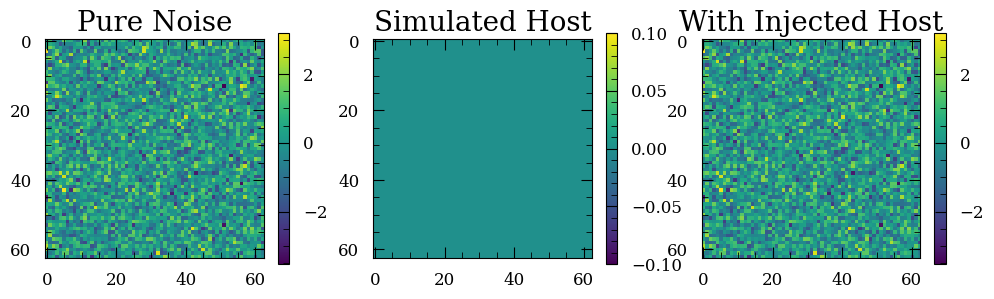

<Figure size 640x480 with 0 Axes>

In [3]:
# Simulate image of size im_size x im_size with NO host (amp = 0)
amp = 0
im_size = 63
_, _, tpl_data = simulate_data(amp, im_size, show_plots=True)

In [5]:
output_table = ps.detect_host_with_powerspectrum(tpl_image=tpl_data, metric='kstest', N_iter=200)

In [6]:
# Print the output table
## Notice the p-value, which we will take as our null result, as we know there is not a host in this case
output_table

IMAGE_TYPE,CUTOUT_SIZE,STATISTIC,PVALUE
str8,int64,float64,float64
TEMPLATE,7,0.09655778894472361,0.04656187268923195
TEMPLATE,15,0.27153266331658293,2.1826781103095693e-13
TEMPLATE,29,0.10613065326633164,0.021398332300803496


Now, check values of the KS test (or Anderson-Darling test) for when there is a host.

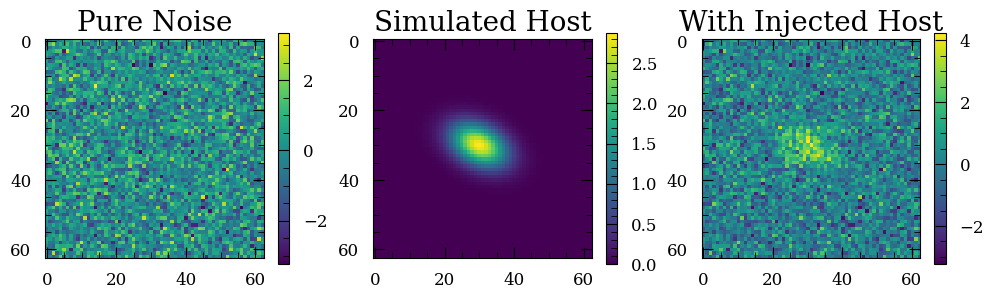

<Figure size 640x480 with 0 Axes>

In [7]:
# Simulate image of size im_size x im_size with a host of specified amplitude
amp = 20
im_size = 63
_, _, tpl_data = simulate_data(amp, im_size, show_plots=True)

In [9]:
# Run the power spectrum test on the simulated image
## I input the simulated data as "template" image, but in the simulated data case it doesn't matter.
## You could also input as the "science" image (sci_image).
output_table = ps.detect_host_with_powerspectrum(tpl_image=tpl_data, metric='kstest', N_iter=200)

In [10]:
# Print the output table
## Notice that the p-value indicates that 
output_table

IMAGE_TYPE,CUTOUT_SIZE,STATISTIC,PVALUE
str8,int64,float64,float64
TEMPLATE,7,0.16467336683417083,3.6822830941249335e-05
TEMPLATE,15,0.5525376884422111,2.4202773132978852e-57
TEMPLATE,29,0.9998994974874372,0.0


## Test on Real Data

In [11]:
objectID = 'ZTF18aajwbhh'

# Load in the science image and the associated segmentation mask from SExtractor
sci_seg = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_SCI_0145_SEG.fits')
sci_image = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_SCI_0145.fits')

# Load in the template image and the associated segmentation mask from SExtractor
temp_seg = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_TEMP_0145_SEG.fits')
temp_image = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/sexoutput/{objectID}_TEMP_0145.fits')

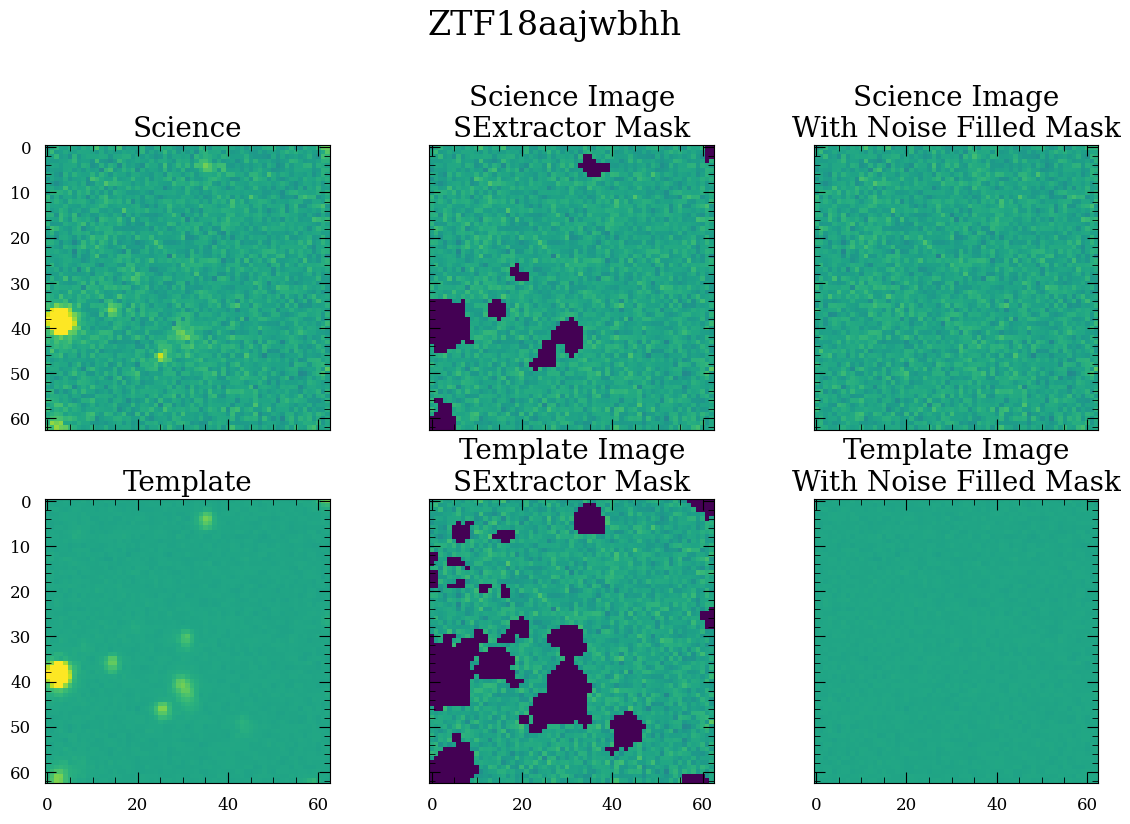

In [12]:
# Create subplots to show all 
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle(objectID, fontsize=24, y=1.02)

# Show the science image
ax[0,0].imshow(sci_image[0].data, vmin=0, vmax=300)
ax[0,0].set_title('Science')

# Show the SExtractor mask for the science image
mask = sci_seg[0].data == 0
ax[0,1].imshow(np.where(mask, sci_image[0].data, -9999), vmin=0, vmax=300)
ax[0,1].set_title('Science Image\nSExtractor Mask')

# Show the masked science image with the masked locations filled with random noise
mask = sci_seg[0].data > 0
for_filling = np.random.normal(np.median(sci_image[0].data[~mask]), np.std(sci_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, sci_image[0].data)
sci_data = to_fill + for_filling
ax[0,2].imshow(sci_data, vmin=0, vmax=300)
ax[0,2].set_title('Science Image\nWith Noise Filled Mask')


# Show the template image
ax[1,0].imshow(temp_image[0].data, vmin=0, vmax=300)
ax[1,0].set_title('Template')

# Show the SExtractor mask for the template image
mask = temp_seg[0].data == 0
ax[1,1].imshow(np.where(mask, sci_image[0].data, -9999), vmin=0, vmax=300)
ax[1,1].set_title('Template Image\nSExtractor Mask')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg[0].data > 0
for_filling = np.random.normal(np.median(temp_image[0].data[~mask]), np.std(temp_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, temp_image[0].data)
tpl_data = to_fill + for_filling
ax[1,2].imshow(tpl_data, vmin=0, vmax=300)
ax[1,2].set_title('Template Image\nWith Noise Filled Mask')

fig.tight_layout()
fig.show()

In [13]:
# Run the power spectrum test on the science image and the template image
output_table = ps.detect_host_with_powerspectrum(sci_image=sci_data, tpl_image=tpl_data, metric='kstest', N_iter=200)

In [14]:
# Print the output table
## There does not appear to be a host, as the template has a (relatively) large p-value when looking at the 29x29 cutout, indicating that the
## distribution of real to shuffled distances is (relatively) highly consistent with the distribution of shuffled to shuffled images, which
## we know are are just noise.
output_table

IMAGE_TYPE,CUTOUT_SIZE,STATISTIC,PVALUE
str8,int64,float64,float64
SCIENCE,7,0.08298994974874374,0.12356443089622926
SCIENCE,15,0.25399497487437184,9.530408876393723e-12
SCIENCE,29,0.3376884422110553,1.2076698665998844e-20
TEMPLATE,7,0.050175879396984924,0.681969780227087
TEMPLATE,15,0.2336934673366834,5.412170764630052e-10
TEMPLATE,29,0.3857788944723618,4.998484069385521e-27
